# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
# The code is written with the help of OpenAI's ChatGPT.com

In [2]:
# Define a function to calculate interest rates from discount factors
def discount_to_intrate(discount, maturity, n_compound=None):

    # If the compounding frequency is not provided, assume continuous compounding
    if n_compound is None:
        # Calculate the continuously compounded interest rate
        intrate = - np.log(discount) / maturity
    else:
        # Calculate the interest rate with discrete compounding
        intrate = n_compound * (1 / discount**(1 / (n_compound * maturity)) - 1)
    
    # Return the computed interest rate
    return intrate

# Convert the Interest/Discount Rate to Discount Factor
def intrate_to_discount(intrate, maturity, n_compound=None):
    # Converts interest rates into discount factors for time value of money calculations.
    # If compounding frequency is not specified, continuous compounding is assumed.
    
    if n_compound is None:
        # Compute the discount factor using the continuous compounding formula:
        # discount = e^(-rate * maturity)
        discount = np.exp(-intrate * maturity)
    else:
        # Compute the discount factor using periodic compounding:
        # discount = 1 / (1 + rate/n_compound)^(n_compound * maturity)
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)
    
    return discount  # Return the computed discount factor.

def get_coupon_dates(quote_date, maturity_date):
    # Check if quote_date is a string; if yes, convert it to a datetime object
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    # Check if maturity_date is a string; if yes, convert it to a datetime object
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # Calculate the number of semi-annual periods between quote_date and maturity_date
    # Use ceil to ensure we cover the full period (even if partial)
    num_periods = np.ceil((maturity_date - quote_date).days / 180)
    
    # Generate semi-annual dates going backward from the maturity date
    temp = pd.date_range(
        end=maturity_date, 
        periods=num_periods, 
        freq=pd.DateOffset(months=6)
    )
    
    # Keep only the dates that are after the quote date
    temp = pd.DataFrame(data=temp[temp > quote_date])
    
    # Extract the first column of the DataFrame and return it as the result
    out = temp[0]
    return out


def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    # Initialize an empty list to store the benchmark dates
    mask_benchmark_dts = []
    
    # Loop through each column (date) in the cash flow DataFrame
    for col in CF.columns:
        # If filtering by benchmark dates is enabled
        if filter_benchmark_dates:
            # Check if the date is one of the benchmark dates (Feb 15, May 15, Aug 15, Nov 15)
            if col.month in [2, 5, 8, 11] and col.day == 15:
                mask_benchmark_dts.append(col)  # Add it to the list of benchmark dates
        else:
            # If not filtering by benchmark dates, include all dates
            mask_benchmark_dts.append(col)

    # If filtering by maturity dates is enabled
    if filter_maturity_dates:
        # Select columns where at least one cash flow >= 100 (indicating maturity)
        mask_maturity_dts = CF.columns[(CF >= 100).any()]
    else:
        # If not filtering by maturity dates, include all columns
        mask_maturity_dts = CF.columns

    # Combine the two filters: Keep only dates present in both lists
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    # Filter the cash flow DataFrame to include only the selected dates
    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # Strict filtering: Keep only rows where cash flows on included dates match the original cash flows
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]
    else:
        # Lenient filtering: Keep rows with at least one non-zero cash flow on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
    # Remove columns (dates) where all cash flows are zero
    CF_filtered = CF_filtered.loc[:, (CF_filtered > 0).any()]
    
    # Return the filtered cash flow DataFrame
    return CF_filtered


def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['quote date'].values[-1]
    
    outdata = outdata[outdata['quote date']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['maturity date'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['maturity date'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['maturity date'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['type'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['ytm']>0]
        
    return outdata


def calc_cashflows(quote_data, filter_maturity_dates=False):
    # Create an empty DataFrame to store cash flows
    # Rows represent individual securities (indexed by quote_data.index)
    # Columns represent unique maturity dates from the data
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    # Iterate over each security in the dataset
    for i in quote_data.index:
        # Get the semi-annual coupon payment dates for the security
        coupon_dates = get_coupon_dates(quote_data.loc[i, 'quote date'], quote_data.loc[i, 'maturity date'])

        # If coupon dates exist (not None), set coupon payment amounts
        if coupon_dates is not None:
            # Add semi-annual coupon payments (coupon rate divided by 2)
            CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2

        # Add the face value (100) at maturity
        CF.loc[i, quote_data.loc[i, 'maturity date']] += 100

    # Replace any NaN values with 0 and sort columns by date
    CF = CF.fillna(0).sort_index(axis=1)
    
    # Remove columns (dates) where all cash flows are zero
    CF.drop(columns=CF.columns[(CF == 0).all()], inplace=True)

    # If filtering by maturity dates is requested, apply the filter function
    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    # Return the final cash flow DataFrame
    return CF


def get_maturity_delta(t_maturity, t_current):
    # Calculates the time-to-maturity in years based on the difference between maturity date and current date.
    # Time is expressed as a fraction of a year (365.25 days to account for leap years).
    
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')  # Convert timedelta to years.
    
    return maturity_delta  # Return the time-to-maturity in years.

def bootstrap(params, maturity):
    # Extract estimated maturities from the first element of params
    estimated_maturities = params[0]
    # Extract corresponding discount factors (betas) from the second element of params
    betas = params[1]
    # Convert discount factors to interest rates using the discount_to_intrate function
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    # Create an interpolation function for the rates based on maturities
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    # Use the interpolation function to estimate the rate at the given maturity
    rate = f(maturity)
    
    # Return the interpolated rate
    return rate

def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    # Prices future cash flows using an interest rate model and optionally converts rates to discount factors.
    
    # Compute the time-to-maturity for all cash flow dates.
    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        # Initialize an array to store discount factors.
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            # Convert rates (from model) to discount factors using the specified model.
            disc[i] = intrate_to_discount(fun_model(params, mat), mat)
    else:
        # If no discounting is required, use rates directly from the model.
        disc = fun_model(params, maturity)
        
    if price_coupons:
        price = CF * disc
    else:
        # price = cash flow matrix multiply discount factors
        price = CF @ disc
    
    return price

def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    # Computes the difference (error) between observed market prices and model-derived prices.
    # The objective is to minimize this error during model calibration.

    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)  # Get model-derived prices.
    
    if isinstance(observed_prices, (pd.DataFrame, pd.Series)):
        # Convert observed prices to NumPy array if they are in Pandas format.
        observed_prices = observed_prices.values
    
    error = sum((observed_prices - price_modeled)**2)  # Compute the sum of squared differences.
    
    return error  # Return the sum of squared errors.

def nelson_siegel(params, maturity):
    # Nelson-Siegel model is used to fit yield curves with a combination of level, slope, and curvature components.
    # params: [beta_0, beta_1, beta_2, tau], where beta's control curve shape and tau is the decay factor.
    
    rate = (
        params[0] +  # Level component (long-term interest rate).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Weighted adjustment factor.
        params[2] * np.exp(-maturity / params[3])  # Curvature component decay.
    )
    return rate  # Return the modeled interest rate for the given maturity.

def nelson_siegel_extended(params, maturity):
    # Implements the extended Nelson-Siegel model for yield curve fitting.
    # params: A list of parameters [beta_0, beta_1, beta_2, tau_1, beta_3, tau_2]
    # - beta_0: Level parameter (long-term rate).
    # - beta_1: Slope parameter (short-term rate adjustment).
    # - beta_2: Curvature parameter (medium-term adjustment).
    # - tau_1: Decay factor for the slope and curvature components.
    # - beta_3: Second curvature parameter for additional flexibility.
    # - tau_2: Decay factor for the second curvature component.
    # maturity: Array or scalar of times to maturity (in years).

    rate = (
        params[0] +  # Long-term level component (constant for all maturities).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Slope/curvature weighted adjustment.
        params[2] * np.exp(-maturity / params[3]) +  # Exponential decay of the first curvature.
        params[4] * (  # Second curvature adjustment with separate parameters.
            (1 - np.exp(-maturity / params[5])) / (maturity / params[5]) -  # Weighted adjustment for second curvature.
            np.exp(-maturity / params[5])  # Exponential decay of the second curvature.
        )
    )
    
    return rate  # Returns the modeled interest rate for the given maturity.

def estimate_curve_ols(CF, prices, interpolate=False):
    # Estimates discount factors using linear regression (ordinary least squares).
    
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        # Ensure the alignment between cash flows and observed prices.
        prices = prices[CF.index].values
    
    # Fit a regression model where cash flows explain observed prices (no intercept).
    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)
    
    if interpolate:
        # Interpolate discount factors to obtain a smooth curve.
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())  # Maturity grid for interpolation.
        
        # Identify valid discount factors within a reasonable range.
        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)
        
        xold = matgrid[dts_valid]  # Valid maturities.
        yold = mod.coef_[dts_valid]  # Valid discount factors.
        xnew = matgrid  # Full maturity grid.
        
        # Create an interpolation function to estimate discount factors for all maturities.
        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)  # Compute interpolated discount factors.
    else:
        discounts = mod.coef_  # Use OLS coefficients directly as discount factors.
        
    return discounts  # Return discount factors (direct or interpolated).

def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    # Estimates parameters for an interest rate curve model by minimizing pricing errors.
    
    if model is bootstrap:
        # Use bootstrap method to estimate discount factors first.
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        # Calculate maturities for each cash flow.
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
        
        # Combine maturities and corresponding discount factors as model parameters.
        params_optimized = [CF_intervals, params]
    else:
        # Provide default initial guess if none is specified.
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10  # Default guess for Nelson-Siegel model parameters.
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)  # Default guess for extended model.
            else:
                x0 = 1  # Generic default initial guess.
        
        # Optimize the model parameters to minimize pricing errors.
        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x  # Extract optimized parameters.
    
    return params_optimized  # Return the estimated model parameters.


def price_treasury_ytm(yield_to_maturity, coupon_rate, face_value, time_to_maturity, payments_per_year=2):
    """
    Prices a Treasury bond based on its yield to maturity, coupon rate, face value, and time to maturity.

    Parameters:
        yield_to_maturity (float): The annual yield to maturity (as a decimal, e.g., 0.03 for 3%).
        coupon_rate (float): The annual coupon rate (as a decimal, e.g., 0.02 for 2%).
        face_value (float): The face value (par value) of the bond.
        time_to_maturity (float): The time to maturity of the bond in years.
        payments_per_year (int): The number of coupon payments per year (default is 2 for semi-annual payments).

    Returns:
        float: The price of the Treasury bond.
    """
    # Calculate the coupon payment per period
    coupon_payment = coupon_rate * face_value / payments_per_year

    # Total number of periods
    total_periods = int(time_to_maturity * payments_per_year)

    # Periodic yield to maturity
    periodic_yield = yield_to_maturity / payments_per_year

    # Price calculation: Sum of discounted coupon payments + discounted face value
    price = 0

    for t in range(1, total_periods + 1):
        price += coupon_payment / (1 + periodic_yield) ** t

    # Add the present value of the face value (paid at maturity)
    price += face_value / (1 + periodic_yield) ** total_periods

    return price

# Duration for a fixed rate bond
# freq = frequency of compounding in a year
# tau = years-to-maturity

def duration_closed_formula(tau, ytm, coupon_rate=None, freq=2):

    if coupon_rate is None:
        coupon_rate = ytm
        
    # y_tilde = ytm/frequency
    y = ytm/freq
    # c_tilde = coupon rate/ frequency
    c = coupon_rate/freq
    # tau_tilde= tau * frequency
    T = tau * freq
        
    if coupon_rate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'dirty price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['dirty price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [3]:
# Specify the quote date
QUOTE_DATE = '2024-10-31'

# Importing the excel file
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='selected quotes')
rawdata.head(5)

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208042,note,2024-10-31,2023-04-30,2025-04-30,0.495551,0,3.875,99.712500,99.722203,99.717351,0,99.717351,0.044933
1,208129,note,2024-10-31,2023-10-31,2025-10-31,0.999316,0,5.000,100.641406,100.660819,100.651113,0,100.651113,0.043311
2,208213,note,2024-10-31,2024-04-30,2026-04-30,1.494867,0,4.875,100.929688,100.960938,100.945312,0,100.945312,0.042327
3,208302,note,2024-10-31,2024-10-31,2026-10-31,1.998631,0,4.125,99.933594,99.941406,99.937500,0,99.937500,0.041611
4,207875,note,2024-10-31,2022-04-30,2027-04-30,2.494182,0,2.750,96.750000,96.781250,96.765625,0,96.765625,0.041346


### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [4]:
import pandas as pd
import numpy as np

# Define constants
face_value = 100  # Normalized face value of $100

# Generate a range of payment dates, assuming semi-annual payments
# The range starts from the earliest issue date in the dataset and ends at the latest maturity date
payment_dates = pd.date_range(start=rawdata['quote date'].min(),  # Minimum quote date
                              end=rawdata['maturity date'].max(),  # Maximum maturity date
                              freq='6ME')  # Semi-annual frequency (6ME)

# Initialize a cash flow matrix with zeros
# Rows represent Treasury issues, and columns represent payment dates
cashflow_matrix = np.zeros((len(rawdata), len(payment_dates)))

# Iterate through each Treasury issue in the dataset
for i, row in rawdata.iterrows():
    # Extract the issue date and maturity date for the current Treasury issue
    issue_date = pd.to_datetime(row['issue date'])  # Convert issue date to a datetime object
    maturity_date = pd.to_datetime(row['maturity date'])  # Convert maturity date to a datetime object
    cpn_rate = row['cpn rate'] / 100  # Convert the coupon rate from percentage to decimal

    # Identify the payment dates that fall between the issue date and maturity date (inclusive)
    relevant_dates = payment_dates[(payment_dates >= issue_date) & (payment_dates <= maturity_date)]

    # Get the index positions of these relevant dates in the payment_dates list
    payment_indices = [payment_dates.get_loc(date) for date in relevant_dates]

    # Calculate the semi-annual coupon payment amount
    coupon_payment = (cpn_rate / 2) * face_value  # Divide the annual coupon rate by 2 for semi-annual payments

    # Assign coupon payments to the matrix for all relevant payment dates except the last one
    cashflow_matrix[i, payment_indices[:-1]] = coupon_payment  # Assign coupon payments

    # Add the face value (principal) to the last payment date along with the final coupon payment
    cashflow_matrix[i, payment_indices[-1]] = coupon_payment + face_value  # Final payment = coupon + face value

# Convert the cash flow matrix to a DataFrame for better readability
# Rows are indexed by KYTREASNO (unique Treasury identifiers), and columns are the payment dates
cashflow_df = pd.DataFrame(cashflow_matrix, 
                           index=rawdata['KYTREASNO'],  # Use Treasury identifiers as row indices
                           columns=payment_dates)  # Use payment dates as column names

# Display the cash flow DataFrame to verify the results
(cashflow_df.head(5))


,2024-10-31,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,,
208042,1.9375,101.9375,0.0000,0.0000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208129,2.5000,2.5000,102.5000,0.0000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208213,2.4375,2.4375,2.4375,102.4375,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208302,2.0625,2.0625,2.0625,2.0625,102.0625,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207875,1.3750,1.3750,1.3750,1.3750,1.3750,101.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Define the cutoff date for filtering
cutoff_date = pd.Timestamp("2025-04-30")

# Filter columns in the cash flow matrix based on payment dates
future_dates = payment_dates[payment_dates >= cutoff_date]  # Select only future payment dates
filtered_cashflow_matrix = cashflow_matrix[:, payment_dates >= cutoff_date]  # Filter columns

# Create a new DataFrame for the adjusted cash flow matrix
adjusted_cashflow_df = pd.DataFrame(filtered_cashflow_matrix, 
                                    index=rawdata['KYTREASNO'],  # Row indices (Treasury IDs)
                                    columns=future_dates)  # Columns (future payment dates)

# Display the adjusted cash flow matrix
(adjusted_cashflow_df) # This is the final cash flow matrix

,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [6]:
# Calculate the dirty price using the average of BID and ASK and add the accrued interest
dirty_price = ((rawdata['ask'] + rawdata['bid'])/2) + + rawdata['accrued int']
p = dirty_price.values
p

array([ 99.71735135, 100.6511126 , 100.9453125 ,  99.93749995,
        96.765625  , 100.00390625,  97.92187495, 102.6035156 ,
       101.91210935,  99.89453125,  96.6796875 , 103.54492185,
       102.28515625,  99.4453125 ])

In [7]:
import numpy as np

# Calculate the dirty price using the average of BID and ASK and add the accrued interest
dirty_price = ((rawdata['ask'] + rawdata['bid'])/2) + rawdata['accrued int']
p = dirty_price.values

# Use the cash flow matrix C (generated earlier)
# in this case, it's adjusted_cashflow_df
C = adjusted_cashflow_df

# Solve the linear system p = C * z to estimate the spot discount factors z
# Use numpy's linear algebra solver
z = np.linalg.solve(C, p)

# Display the estimated spot discount factors
# index = future_dates
spot_discount_factors = pd.Series(z, index=future_dates, name="Spot Discount Factors")
# print(spot_discount_factors)

# Optionally, save to a DataFrame for better presentation
spot_discount_df = pd.DataFrame({"Date": future_dates, "Spot Discount Factor": z})
spot_discount_df


,Date,Spot Discount Factor
0,2025-04-30,0.978220
1,2025-10-31,0.958103
2,2026-04-30,0.939358
3,2026-10-31,0.921067
4,2027-04-30,0.903034
5,2027-10-31,0.884856
6,2028-04-30,0.866327
7,2028-10-31,0.848120
8,2029-04-30,0.831110
9,2029-10-31,0.814462


### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

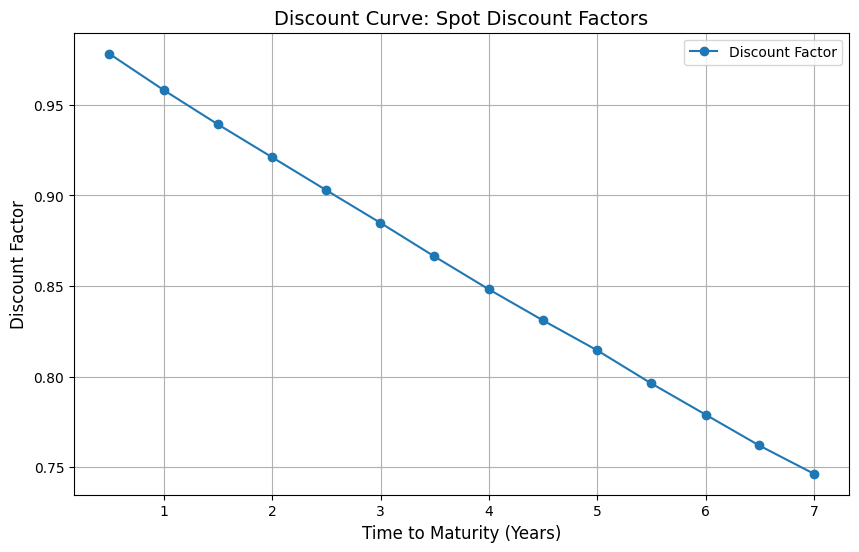

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Current date (2024-10-31)
current_date = pd.Timestamp("2024-10-31")

# Calculate time to maturity (in years) for each payment date
time_to_maturity = [(date - current_date).days / 365.25 for date in spot_discount_factors.index]

# Plot the discount factor curve
plt.figure(figsize=(10, 6))
plt.plot(time_to_maturity, spot_discount_factors.values, marker='o', linestyle='-', label='Discount Factor')

# Add labels and title
plt.xlabel('Time to Maturity (Years)', fontsize=12)
plt.ylabel('Discount Factor', fontsize=12)
plt.title('Discount Curve: Spot Discount Factors', fontsize=14)
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


In [9]:
# Continuously Compounded
discount = np.array(spot_discount_factors)
maturity = np.array(time_to_maturity)
int_cont = discount_to_intrate(discount, maturity, n_compound=None)

spot_discount_df['Cont. Compounded Rate'] = int_cont
spot_discount_df

,Date,Spot Discount Factor,Cont. Compounded Rate
0,2025-04-30,0.978220,0.044436
1,2025-10-31,0.958103,0.042829
2,2026-04-30,0.939358,0.041849
3,2026-10-31,0.921067,0.041139
4,2027-04-30,0.903034,0.040893
5,2027-10-31,0.884856,0.040805
6,2028-04-30,0.866327,0.041042
7,2028-10-31,0.848120,0.041183
8,2029-04-30,0.831110,0.041150
9,2029-10-31,0.814462,0.041051


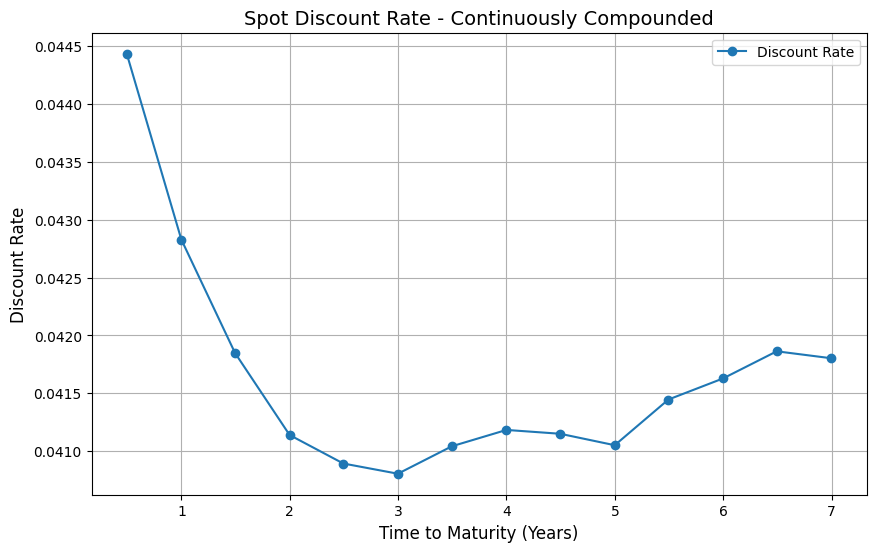

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Current date (2024-10-31)
current_date = pd.Timestamp("2024-10-31")

# Calculate time to maturity (in years) for each payment date
time_to_maturity = [(date - current_date).days / 365.25 for date in spot_discount_factors.index]

# Plot the discount factor curve
plt.figure(figsize=(10, 6))
plt.plot(time_to_maturity, int_cont, marker='o', linestyle='-', label='Discount Rate')

# Add labels and title
plt.xlabel('Time to Maturity (Years)', fontsize=12)
plt.ylabel('Discount Rate', fontsize=12)
plt.title('Spot Discount Rate - Continuously Compounded', fontsize=14)
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


In [11]:
# Semi-Annually Compounded
discount = np.array(spot_discount_factors)
maturity = np.array(time_to_maturity)
int_semi = discount_to_intrate(discount, maturity, n_compound=2)

spot_discount_df['Discount Rate Semi-Annually Compounded'] = int_semi
spot_discount_df

,Date,Spot Discount Factor,Cont. Compounded Rate,Discount Rate Semi-Annually Compounded
0,2025-04-30,0.978220,0.044436,0.044933
1,2025-10-31,0.958103,0.042829,0.043291
2,2026-04-30,0.939358,0.041849,0.042290
3,2026-10-31,0.921067,0.041139,0.041565
4,2027-04-30,0.903034,0.040893,0.041314
5,2027-10-31,0.884856,0.040805,0.041224
6,2028-04-30,0.866327,0.041042,0.041466
7,2028-10-31,0.848120,0.041183,0.041610
8,2029-04-30,0.831110,0.041150,0.041576
9,2029-10-31,0.814462,0.041051,0.041475


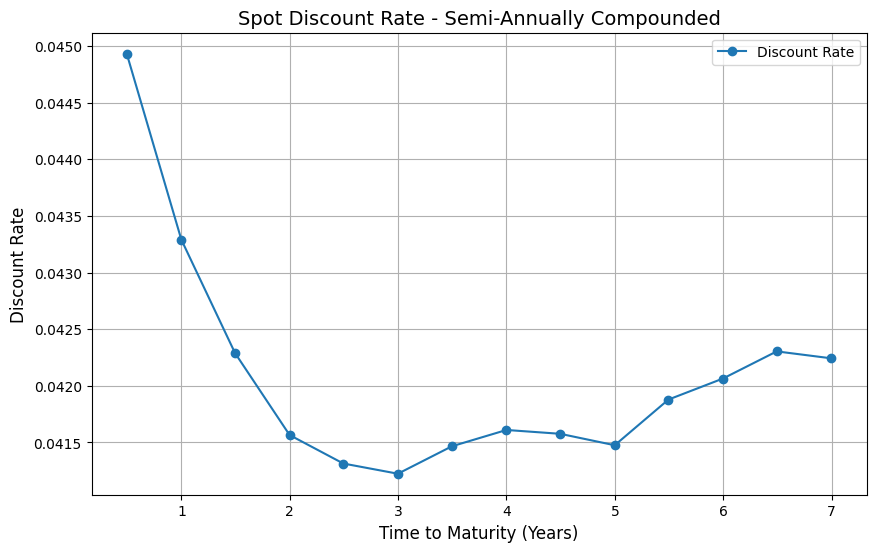

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Current date (2024-10-31)
current_date = pd.Timestamp("2024-10-31")

# Calculate time to maturity (in years) for each payment date
time_to_maturity = [(date - current_date).days / 365.25 for date in spot_discount_factors.index]

# Plot the discount factor curve
plt.figure(figsize=(10, 6))
plt.plot(time_to_maturity, int_semi, marker='o', linestyle='-', label='Discount Rate')

# Add labels and title
plt.xlabel('Time to Maturity (Years)', fontsize=12)
plt.ylabel('Discount Rate', fontsize=12)
plt.title('Spot Discount Rate - Semi-Annually Compounded', fontsize=14)
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [13]:
import pandas as pd
import numpy as np

# Define constants
face_value = 100  # Normalized face value of $100

# Generate a range of payment dates, assuming semi-annual payments
# The range starts from the earliest issue date in the dataset and ends at the latest maturity date
payment_dates = pd.date_range(start=rawdata['quote date'].min(),  # Minimum quote date
                              end=rawdata['maturity date'].max(),  # Maximum maturity date
                              freq='6ME')  # Semi-annual frequency (6ME)

# Initialize a cash flow matrix with zeros
# Rows represent Treasury issues, and columns represent payment dates
cashflow_matrix = np.zeros((len(rawdata), len(payment_dates)))

# Iterate through each Treasury issue in the dataset
for i, row in rawdata.iterrows():
    # Extract the issue date and maturity date for the current Treasury issue
    issue_date = pd.to_datetime(row['issue date'])  # Convert issue date to a datetime object
    maturity_date = pd.to_datetime(row['maturity date'])  # Convert maturity date to a datetime object
    cpn_rate = row['cpn rate'] / 100  # Convert the coupon rate from percentage to decimal

    # Identify the payment dates that fall between the issue date and maturity date (inclusive)
    relevant_dates = payment_dates[(payment_dates >= issue_date) & (payment_dates <= maturity_date)]

    # Get the index positions of these relevant dates in the payment_dates list
    payment_indices = [payment_dates.get_loc(date) for date in relevant_dates]

    # Calculate the semi-annual coupon payment amount
    coupon_payment = (cpn_rate / 2) * face_value  # Divide the annual coupon rate by 2 for semi-annual payments

    coupon_payment_adj = coupon_payment * (1.005)

    # Assign coupon payments to the matrix for all relevant payment dates except the last one
    cashflow_matrix[i, payment_indices[:-1]] = coupon_payment_adj  # Assign coupon payments

    # Add the face value (principal) to the last payment date along with the final coupon payment
    cashflow_matrix[i, payment_indices[-1]] = coupon_payment_adj + face_value  # Final payment = coupon + face value

# Convert the cash flow matrix to a DataFrame for better readability
# Rows are indexed by KYTREASNO (unique Treasury identifiers), and columns are the payment dates
cashflow_df = pd.DataFrame(cashflow_matrix, 
                           index=rawdata['KYTREASNO'],  # Use Treasury identifiers as row indices
                           columns=payment_dates)  # Use payment dates as column names


In [14]:
# Define the cutoff date for filtering
cutoff_date = pd.Timestamp("2025-04-30")

# Filter columns in the cash flow matrix based on payment dates
future_dates = payment_dates[payment_dates >= cutoff_date]  # Select only future payment dates
filtered_cashflow_matrix = cashflow_matrix[:, payment_dates >= cutoff_date]  # Filter columns

# Create a new DataFrame for the adjusted cash flow matrix
adjusted_cashflow_df = pd.DataFrame(filtered_cashflow_matrix, 
                                    index=rawdata['KYTREASNO'],  # Row indices (Treasury IDs)
                                    columns=future_dates)  # Columns (future payment dates)

# Display the adjusted cash flow matrix
(adjusted_cashflow_df) # This is the final cash flow matrix

,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.947187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208129,2.512500,102.512500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208213,2.449687,2.449687,102.449687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208302,2.072812,2.072812,2.072812,102.072812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207875,1.381875,1.381875,1.381875,1.381875,101.381875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
207960,2.072812,2.072812,2.072812,2.072812,2.072812,102.072812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208044,1.758750,1.758750,1.758750,1.758750,1.758750,1.758750,101.758750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208132,2.449687,2.449687,2.449687,2.449687,2.449687,2.449687,2.449687,102.449687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208216,2.324062,2.324062,2.324062,2.324062,2.324062,2.324062,2.324062,2.324062,102.324062,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
int_cont_adj = int_cont * 1.005
int_cont_adj

array([0.04465793, 0.04304341, 0.04205794, 0.04134508, 0.04109756,
       0.04100878, 0.04124736, 0.04138922, 0.04135594, 0.04125644,
       0.04165357, 0.04183656, 0.04207238, 0.04201207])

In [16]:
intrate = np.array(int_cont_adj)
maturity = np.array(time_to_maturity)

disc_factor_adj = intrate_to_discount(intrate, maturity, n_compound=None)
disc_factor_adj

array([0.97811279, 0.95789803, 0.9390646 , 0.92068847, 0.90257382,
       0.88431482, 0.86570551, 0.84742166, 0.83034192, 0.81362642,
       0.79542332, 0.77805188, 0.76092102, 0.74527779])

In [17]:
# price = Cash flow matrix multiply by discount factor matrix (p = C x z)
price_adj = adjusted_cashflow_df @ disc_factor_adj

# Save to a DataFrame for better presentation
price_adj_df = pd.DataFrame({"Adjusted Price": price_adj})
price_adj_df


,Adjusted Price
KYTREASNO,
208042,99.715848
208129,100.654030
208213,100.949496
208302,99.936754
207875,96.749898
207960,100.003274
208044,97.911601
208132,102.614546
208216,101.919806


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

In [18]:
# Specify the quote date
QUOTE_DATE = '2024-10-31'

# Importing the excel file
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
df_quotes = pd.read_excel(filepath_rawdata,sheet_name='quotes')
df_quotes.head(5)

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.0,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
1,208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.0,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
2,208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.0,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
3,208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.0,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
4,204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.5,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497


In [19]:
# df_quotes.rename(columns={
#     'quote date': 'CALDT',
#     'maturity date': 'TMATDT',
#     'cpn rate': 'TCOUPRT',
#     'bid': 'TDBID',
#     'ask': 'TDASK',
#     'price': 'TDNOMPRC',
#     'accrued int': 'TDACCINT',
#     'dirty price': 'TDDIRTYP',
#     'ytm': 'TDYLD',
#     'type': 'ITYPE'
# }, inplace=True)
# df_quotes.columns = df_quotes.columns.str.upper()
df_quotes.sort_values('maturity date', inplace=True)
df_quotes.set_index('KYTREASNO', inplace=True)
df_quotes.head()

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.0,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.0,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.0,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.0,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.5,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497


### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [20]:
# Filter out TIPS and bonds with non-positive YTM
# isin checks if the bond type in the type column matches any of the values in the list 
# ~ operator negates the condition, so bonds with types not in the specified list are selected.
df_nominal = df_quotes[ ~df_quotes['type'].isin([11,12,'TIPS Note','TIPS bond']) ].copy()
df_nominal = df_nominal[df_nominal['ytm']>0]

# Construct cashflow matrix
CF_all = calc_cashflows(df_nominal)
print("CF_all shape:", CF_all.shape)

display(CF_all.head())
display(CF_all.tail())

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: Futur

CF_all shape: (395, 312)


/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0,100,0,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0,0,100,0,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0,0,0,100,0.00,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0,0,0,0,103.75,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208107,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0,0,0,0,2.3750,0,0,0,0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000
208233,0,0,0,0,2.3125,0,0,0,0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125,0.000
208279,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.125,0.0000,102.125


In [21]:
# Find the date with the most cashflow across all issues
# Sum the cashflows for each date (column-wise sum)
most_cashflow_date = CF_all.sum(axis=0).idxmax()  
# Find the maximum total cashflow value
most_cashflow_amount = CF_all.sum(axis=0).max()  
# Print the result with the date and total cashflow
print(f"The date with the most cashflow across all issues is {most_cashflow_date:%Y-%m-%d}, with a total cashflow of ${most_cashflow_amount}.")

The date with the most cashflow across all issues is 2025-02-15, with a total cashflow of $435.25.


In [22]:
# Find the date with the most issues paying a cashflow
# Create a boolean DataFrame where True indicates cashflows greater than 0
issues_paying_cashflow = (CF_all > 0).sum(axis=0)  
# Find the date with the maximum count of issues paying cashflows
most_issues_date = issues_paying_cashflow.idxmax()  
# Find the maximum count of issues paying cashflows
most_issues_count = issues_paying_cashflow.max()  
# Print the result with the date and number of issues
print(f"The date with the most issues paying a cashflow is {most_issues_date:%Y-%m-%d}, with {most_issues_count} issues paying cashflow.")

The date with the most issues paying a cashflow is 2025-02-15, with 80 issues paying cashflow.


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [23]:
# OLS Method
MODEL = bootstrap
quotes = df_quotes
t_current = df_quotes['quote date'].values[0]
CFset = dict()

# OLS Method
RESTRICT_YLD = True
RESTRICT_TIPS = True
RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

label = 'no non-maturity dates'

data = filter_treasuries(quotes, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
CFset[label] = CF

display(CF)

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: Futur

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208222,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208247,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208223,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
204083,0,0,0,0,103.7500,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208105,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375,0.0000,0.0000,0.0000,0.0000
208147,0,0,0,0,2.2500,0,0,0,0,0.0,...,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.0000
208177,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,102.0000,0.0000,0.0000


In [24]:
# Prices 
quotes['dirty price'].loc[CF.index].head()

KYTREASNO
208246     99.947861
208222     99.922439
208247     99.857611
208223     99.832751
204083    103.558498
Name: dirty price, dtype: float64

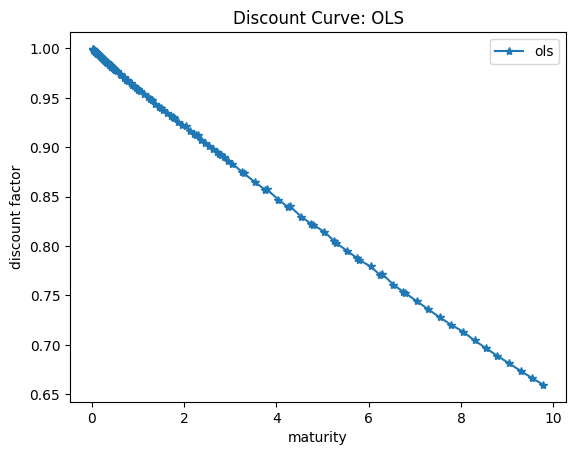

In [25]:
model = bootstrap
prices = quotes['dirty price'].loc[CF.index]
params_OLS = estimate_rate_curve(model, CF, t_current, prices, x0=None)

ols_result_maturity = params_OLS[0]
ols_result_disc_factor = params_OLS[1]

disc_ols = pd.DataFrame({'maturity':ols_result_maturity, 'ols': ols_result_disc_factor}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='-',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

In [26]:
inc = 0.5

maturity_grid = np.arange(inc, disc_ols.index.to_series().max()+.5,inc)

# Use bootstrap function to get the interpolated rate for OLS method
# Use the appropriate parameter and maturity 
ols_rate = bootstrap(params_OLS, maturity_grid)
ols_rate

array([0.04390028, 0.04277268, 0.04178633, 0.04057245, 0.04093502,
       0.04078164, 0.04113799, 0.04099384, 0.04105356, 0.04079531,
       0.04146313, 0.04133083, 0.04172734, 0.0419531 , 0.04212779,
       0.04200936, 0.04230519, 0.04243301, 0.04254058, 0.04252834])

In [27]:
# Dataframe for OLS
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['ols'] = ols_rate
curves_ols.head()

,ols
0.5,0.043900
1.0,0.042773
1.5,0.041786
2.0,0.040572
2.5,0.040935


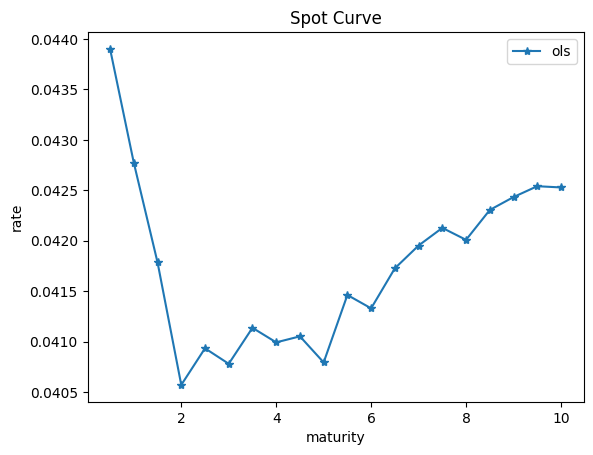

In [28]:
ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

## Additional: Do Bootstrap Method for Discount Curve

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:148: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_85022/1616335146.py:45: Futur

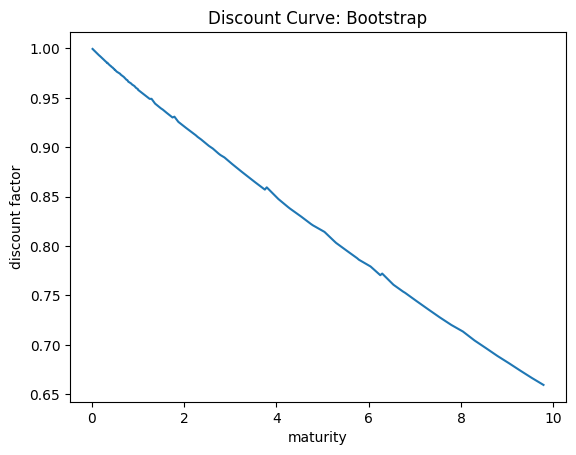

In [29]:
# Bootstrap Method for Discount Curve
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True
RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

data = filter_treasuries(quotes, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

# Price
prices = quotes['dirty price'].loc[CF.index]
# Calculating the Maturity and Discount Factor
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

bootstrap_result_maturity = params_boot[0]
bootstrap_result_disc_factor = params_boot[1]

label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

plt.plot(bootstrap_result_maturity, bootstrap_result_disc_factor)
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

In [30]:
inc = 0.5
maturity_grid = np.arange(inc, disc_ols.index.to_series().max()+.5,inc)

# Use bootstrap function to get the interpolated rate for Bootstrap method
# Use the appropriate parameter and maturity 
bootstrap_rate = bootstrap(params_boot, maturity_grid)
bootstrap_rate

array([0.04391989, 0.04284435, 0.04183224, 0.0411438 , 0.04094407,
       0.04088181, 0.04113131, 0.04076551, 0.04114143, 0.04081731,
       0.04146322, 0.04132936, 0.04171566, 0.04195077, 0.04212335,
       0.04200341, 0.04230032, 0.04242703, 0.042535  , 0.04252584])

In [31]:
# Dataframe for Curves 
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['ols'] = ols_rate
curves_ols['bootstrap'] = bootstrap_rate

# Rename the index to 'Time to Maturity'
curves_ols.index.name = 'Time to Maturity'

curves_ols.head()

,ols,bootstrap
Time to Maturity,,
0.5,0.043900,0.043920
1.0,0.042773,0.042844
1.5,0.041786,0.041832
2.0,0.040572,0.041144
2.5,0.040935,0.040944


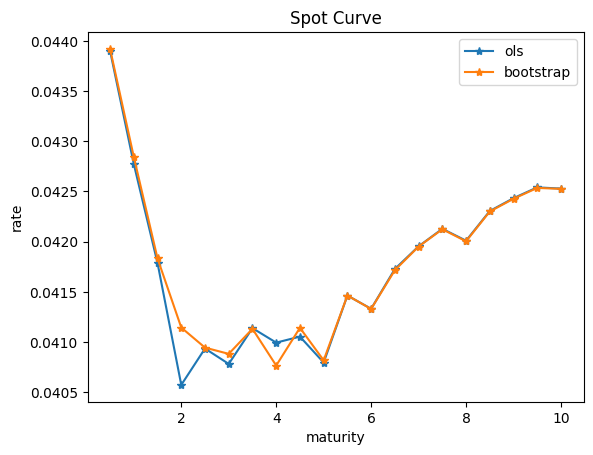

In [32]:
# Dataframe for Curves 
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['ols'] = ols_rate
curves_ols['bootstrap'] = bootstrap_rate

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



In [33]:
# Importing the excel file
filepath_rawdata_2 = f'../data/yields.xlsx'
df_yield_raw = pd.read_excel(filepath_rawdata_2).set_index('caldt')
df_yield = df_yield_raw.copy()
df_yield.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [34]:
# Level = Mean of all yields
df_yield['Level'] = df_yield[[1, 2, 5, 7, 10, 20, 30]].mean(axis=1)
# Slope = 30-year yield - 1-year yield
df_yield['Slope'] = df_yield[30] - df_yield[1]
# Curvature = - 1-year yield + 2 * 10-year yield - 30-year yield
df_yield['Curvature'] = - df_yield[1] + 2*df_yield[10] - df_yield[30]
df_yield.head()

,1,2,5,7,10,20,30,Level,Slope,Curvature
caldt,,,,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172,3.591027,0.879264,0.886559
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316,3.614691,0.893380,0.966721
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049,3.617360,0.900101,0.966566
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543,3.630646,0.916659,1.013983
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018,3.627267,0.892599,0.975574


In [35]:
df_factors = df_yield[['Level', 'Slope', 'Curvature']]
df_factors.head()

,Level,Slope,Curvature
caldt,,,
1961-06-14,3.591027,0.879264,0.886559
1961-06-15,3.614691,0.893380,0.966721
1961-06-16,3.617360,0.900101,0.966566
1961-06-19,3.630646,0.916659,1.013983
1961-06-20,3.627267,0.892599,0.975574


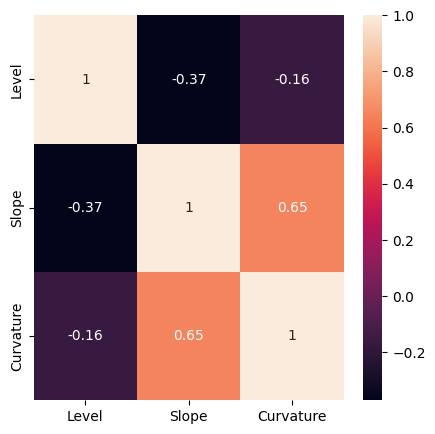

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
correlation_matrix = df_factors.corr()
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns, annot=True);

In [37]:
def summary_statistics_annualized(returns, annual_factor = 12):
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    return summary_statistics

summary_stat = summary_statistics_annualized(df_factors, annual_factor=1)
summary_stat


,Mean,Vol
Level,5.463678,2.903979
Slope,1.098446,1.478564
Curvature,0.660265,0.975464


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [38]:
from sklearn.decomposition import PCA

# Compute principal components using a full Singular Value Decomposition (SVD)
pca = PCA(svd_solver='full')
# Fits the PCA model to the dataset
pca.fit(df_yield_raw)

# Make a new dataframe for the Variation Explained by each Principal Component
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variation Explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))
pca_var_explained.style.format('{:.2%}'.format)

,1,2,3,4,5,6,7
Variation Explained,97.05%,2.55%,0.30%,0.05%,0.04%,0.02%,0.01%


The table above shows that the first factor (and certainly the first 3) explain most variation.

In [39]:
# PCA Loadings
# use the appropriate dataframe
pca_wts = pd.DataFrame(pca.components_,columns=df_yield_raw.columns)
pca_wts.index = ['PC 1: Level','PC 2: Slope','PC 3: Curvature','PCA 4','PCA 5','PCA 6','PCA 7']
pca_wts.head(2).style.format('{:.2f}')

,1,2,5,7,10,20,30
PC 1: Level,0.41,0.41,0.39,0.38,0.36,0.34,0.34
PC 2: Slope,0.59,0.40,0.05,-0.09,-0.20,-0.44,-0.50


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [40]:
# Create an empty DataFrame phi with:
# Index: (maturity terms such as 1, 2, 5, 10, 20, 30).
# Columns: (level, slope, curvature).
phi = pd.DataFrame(index=df_factors.columns, columns=df_yield_raw.columns, dtype=float).T

# For each maturity (column in df_yield), a linear regression is fitted using 
# the factors as the independent variables and the yields (for a specific maturity) as the dependent variable

for col in df_yield.columns:
    phi.loc[col, :] = LinearRegression(fit_intercept=False).fit(df_factors, df_yield[col]).coef_
phi.style.format('{:.2f}')

,Level,Slope,Curvature
1,1.00,-0.45,-0.24
2,1.00,-0.39,-0.03
5,1.00,-0.17,0.18
7,1.00,-0.05,0.22
10,1.00,0.05,0.26
20,1.01,0.46,-0.15
30,1.00,0.55,-0.24
Level,1.00,0.00,0.00
Slope,0.00,1.00,-0.00
Curvature,-0.00,-0.00,1.00


In [41]:
# PCA Factors = Yield x PCA Weights
pca_factors = df_yield_raw @ pca_wts.T
pca_factors.head()

,PC 1: Level,PC 2: Slope,PC 3: Curvature,PCA 4,PCA 5,PCA 6,PCA 7
caldt,,,,,,,
1961-06-14,9.427121,-1.424204,-0.156244,0.031948,0.005137,-0.054228,-0.088338
1961-06-15,9.489326,-1.441303,-0.198485,0.033398,0.006131,-0.059012,-0.077260
1961-06-16,9.496155,-1.446733,-0.202067,0.026885,0.007434,-0.059937,-0.067234
1961-06-19,9.530949,-1.459483,-0.227752,0.021014,0.008531,-0.067309,-0.064436
1961-06-20,9.520727,-1.464235,-0.187763,0.055533,0.013505,-0.046889,-0.057204


In [42]:
# Take only the first 2 columns
pca_factors.iloc[:,0:2].head(3)

,PC 1: Level,PC 2: Slope
caldt,,
1961-06-14,9.427121,-1.424204
1961-06-15,9.489326,-1.441303
1961-06-16,9.496155,-1.446733


In [43]:
# Correlation between the Ad-hoc Level Factor and PC 1, and Correlation between Ad-hoc Slope Factor and PC 2
pd.concat(
    [df_factors.iloc[:,0:2], # First 2 columns from df_dactors
     pca_factors.iloc[:,0:2]], # First 2 columns from pca_factors
    # Ensure the keys are the same
    axis=1, keys=['adhoc', 'pca']).corr().loc['adhoc', 'pca'].style.format('{:.1%}') 

,PC 1: Level,PC 2: Slope
Level,100.0%,-1.2%
Slope,-38.2%,-92.0%
